**AgriVoltaic Analysis Notebook**

This notebook seeks to model the symbiotic relationship between solar photovoltaic energy production systems and agricultural systems. 

The basic idea being that solar photovoltaic cells have an efficiency versus temperature curve similar to this: 

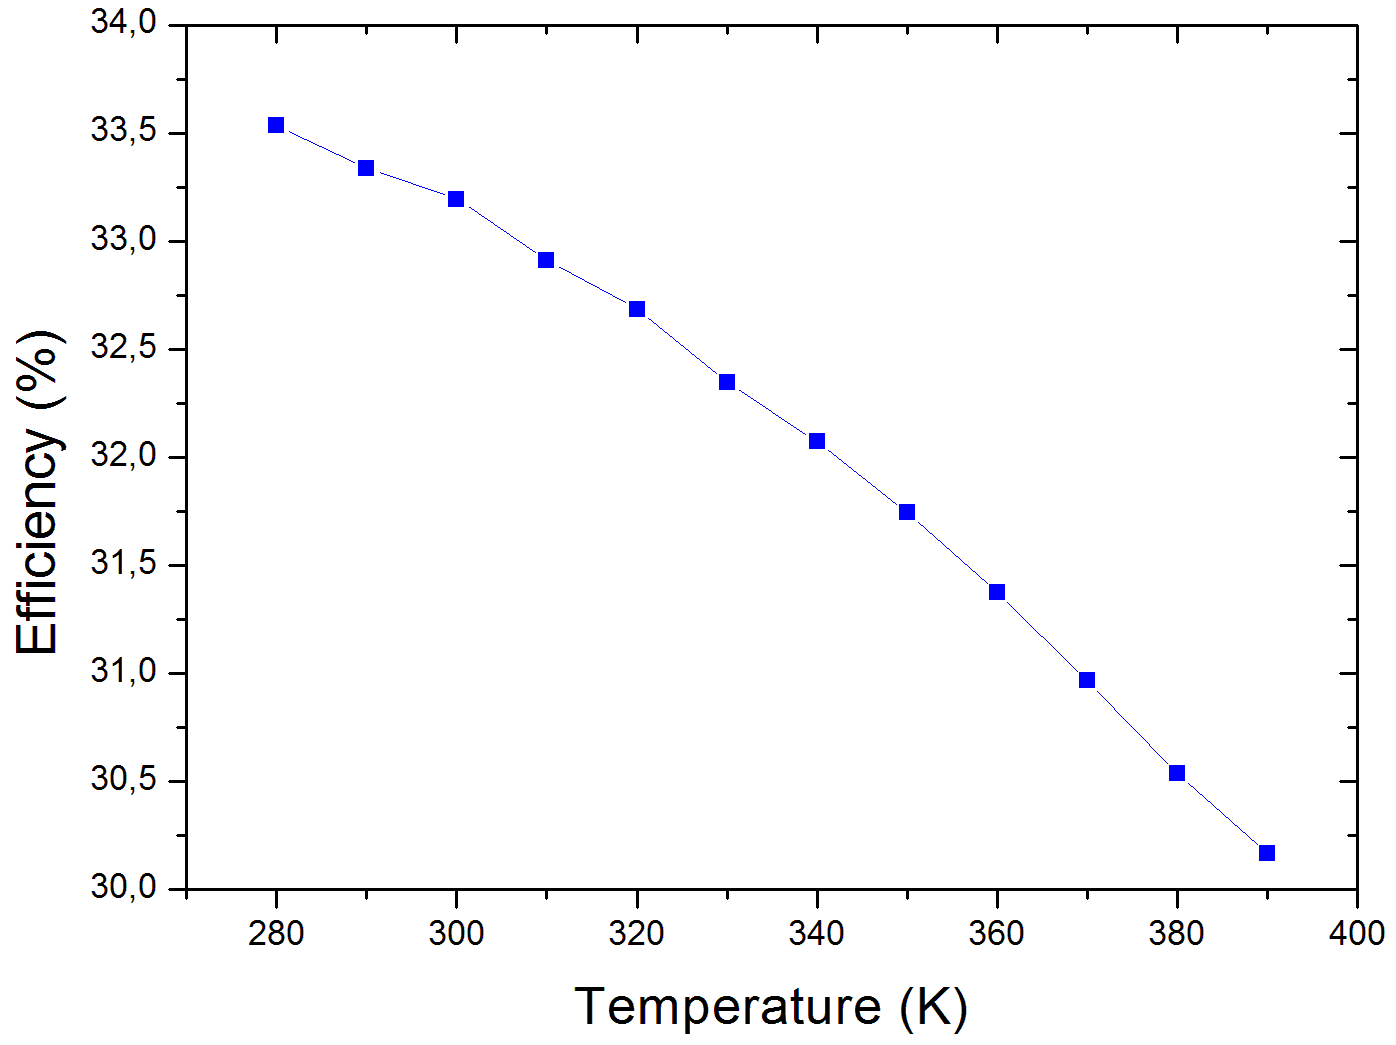  

Reference: http://synergyfiles.com/2017/01/effective_methods_for_cooling_pv-panels/ 


And the symbiotic relationship being that plants transpire (similar to how humans sweat) as shown below:

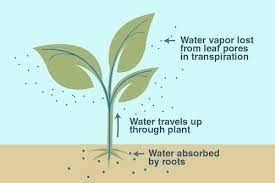




In the transpiration process, water vapor is lost from pores in the leafs. Thus the water evaporates, which effectively pulls heat out fo the surrounding air or pulls heat out of solar panels that are adjacent to the plant. 

Starting off with a simple model of 1 panel and 1 plant:

In [11]:
import numpy as np

# We will assume the panel has the efficiency vs. temperature plot as shown in the curve above:
T = [280.0, 290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0] # Panel temperature in Kelvin
eta = [33.548,	33.347,	33.213,	32.921,	32.695,	32.36,	32.084,	31.749,	31.381,	30.979,	30.544,	30.176] # Panel efficiency

# And we will assume that the plant transpires at a constant rate of 0.3mL/min or 0.0003L/min: https://www.teachengineering.org/activities/view/usf_stormwater_lesson02_activity1
w_dot = 0.0003 #L/min

# if you would like to see more about how transpiration rates may be measured,
# please see: https://www.youtube.com/watch?v=gPsncnQ5TPU&ab_channel=AlexLee


# We will assume that the sun's irradiance reaches a maximum of 1000 Watts on 
# the panel. Of this power:
# 10% is reflected,
# the efficeincy as defined by the curve above is converted to electricity,
# and the remaining power is absorbed as heat. 

# This gives us an absorbed heat rate of:
Q_dot_in = 1000*(1-0.1)*np.subtract(100,eta)/100 # Watts

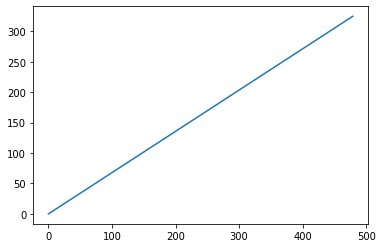

In [16]:
# From here, we need that latent heat of vaporization for water which is:
Q_dot_vap = 2260 #kJ/kg ~= kJ/L as the density of water is ~1kg/L

# Thus, over the course of 8 hours:
time = np.array(range(8*60))
# The plant's transpiration will remove:
Q_dot_out = w_dot*time*Q_dot_vap

import matplotlib.pyplot as plt
plt.plot(time,Q_dot_out)